### DFT validation of top predictions

In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='talk',
    # context='paper',
    # font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
print(np.__version__)
print(pd.__version__)

1.22.1
1.3.5


In [3]:
import nfp
print(nfp.__version__)

2022-05-22 17:29:45.910362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-05-22 17:29:45.910397: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


0.3.6


In [4]:
os.chdir('../')

In [5]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from scripts import ehull

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


In [25]:
# out_dir = "/projects/rlmolecule/jlaw/crystals/2022-01-25/"
# dft_decomp_energies_file = f"{out_dir}/mctsvalidation_Mg80decor_1.csv"
out_dir = "//projects/rlmolecule/jlaw/crystal_outputs/2022-05-04"
# best_decorations.csv
viz_dir = f"{out_dir}"
os.makedirs(viz_dir, exist_ok=True)
# dft_relax_energies = "/projects/rlmolecule/pgorai/mcts_validation_04282022/mcts_validation_04282022.csv"
dft_data = pd.DataFrame()
for dft_relax_file in [
    # "mcts_validation_q3_redone1.csv",
    # "mcts_validation_q3_redone2.csv",
    # "mcts_validation_q2_redone.csv",
    "mcts_validation_05212022.csv",
]:
    dft_relax_energies = f"/projects/rlmolecule/pgorai/mcts_validation_05212022/{dft_relax_file}"
    # df = pd.read_csv(dft_decomp_energies_file, index_col=0, names=['energyperatom', 'decomp_energy'])
    print(f"Reading {dft_relax_energies}")
    curr_dft_data = pd.read_csv(dft_relax_energies)
    print(f"\t{len(curr_dft_data)}")
    dft_data = pd.concat([dft_data, curr_dft_data])
dft_data.head(2)

Reading /projects/rlmolecule/pgorai/mcts_validation_05212022/mcts_validation_05212022.csv
	381


,decoration,numatoms,relaxedvolume,energyperatom
0,K1Sb1F6/K1Sb1F6_sg148_icsd_015343_1,8,132.81,-4.636
1,Na1Hf1Hg1I7/Na1Hf1Hg1I7_sg9_icsd_060952_2,40,2016.09,-2.820


In [46]:
dft_data2 = pd.read_csv("/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa-no-halides-ScY/decomp_energy.csv")
dft_data2.head(2)

,id,energyperatom,decomp_energy
0,K1Sb1F6_sg148_icsd_015343_1,-4.636,-0.501
1,Na1Hf1Hg1I7_sg9_icsd_060952_2,-2.820,0.045


### Compute the decomposition energy for each of them

In [23]:
# Dataframe containing competing phases from NRELMatDB
print("Reading inputs/competing_phases.csv")
df_competing_phases = pd.read_csv('inputs/competing_phases.csv')
print(f"\t{len(df_competing_phases)} lines")
print(df_competing_phases.head(2))

Reading inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4


In [27]:
dft_data['comp'] = dft_data.decoration.apply(lambda x: x.split('/')[0])
dft_data['id'] = dft_data.decoration.apply(lambda x: x.split('/')[1])
dft_data.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id
0,K1Sb1F6/K1Sb1F6_sg148_icsd_015343_1,8,132.81,-4.636,K1Sb1F6,K1Sb1F6_sg148_icsd_015343_1
1,Na1Hf1Hg1I7/Na1Hf1Hg1I7_sg9_icsd_060952_2,40,2016.09,-2.820,Na1Hf1Hg1I7,Na1Hf1Hg1I7_sg9_icsd_060952_2


In [51]:
def compute_decomp_energy(row):
    comp, energyperatom = row.comp, row.energyperatom
    # comp, energyperatom = row.comp, row.pred_energyperatom
    # update: if the composition is in the competing phases,
    # then just compare the predicted energy to the energy of the competing phase
    decomp_energy = ehull.convex_hull_stability(comp,
                                                energyperatom,
                                                df_competing_phases)
    if comp in df_competing_phases['reduced_composition']:
        competing_energy = df_competing_phases.set_index(
            'reduced_composition').loc[comp].energyperatom
        decomp_energy1 = energyperatom - competing_energy
        print(comp, decomp_energy, competing_energy, decomp_energy1)

    return decomp_energy

In [30]:
dft_data['decomp_energy'] = dft_data.progress_apply(compute_decomp_energy, axis=1)

  0%|          | 0/381 [00:00<?, ?it/s]

In [45]:
df_pred['decomp_energy2'] = df_pred.progress_apply(compute_decomp_energy, axis=1)

  0%|          | 0/400 [00:00<?, ?it/s]

In [50]:
df_pred[(df_pred.pred_decomp_energy - df_pred.decomp_energy2).abs() > 0.]

,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,id,structure,dls_volume,decomp_energy2


In [31]:
print(len(dft_data[dft_data['decomp_energy'] < -1]))
print(len(dft_data[dft_data['decomp_energy'] < 0]))
print(len(dft_data[dft_data['decomp_energy'] < 0.05]))

7
271
293


In [9]:
run_id = "batt-icsd-volpred-KLiNa-no-halides-ScY"
# run_id = "volpred-KLiNa"
# run_id = "2022-05-09-batt-icsd-cos-dist-Li"
pred_file = f"{out_dir}/{run_id}/best_decorations.p"
viz_dir = f"{out_dir}/{run_id}/viz"
os.makedirs(viz_dir, exist_ok=True)
df_pred = pd.read_pickle(pred_file)
df_pred.head(2)

,decor_id,reward,pred_decomp_energy,pred_energyperatom,comp,id,structure,dls_volume
409,K1Al1Br4|_1_1_4|orthorhombic|sg33_icsd_404394|1,0.907,-0.907,-3.266222,K1Al1Br4,K1Al1Br4_sg33_icsd_404394_1,"[[7.33708713 8.58120866 1.77059988] Al, [5.957...",1154.463218
1820,K1Al1Cl4|_1_1_4|orthorhombic|sg21_icsd_079527|1,0.099,-0.099,-3.792170,K1Al1Cl4,K1Al1Cl4_sg21_icsd_079527_1,[[2.73436021e-16 2.73436021e-16 4.46554911e+00...,1509.532585


In [32]:
# now make a scatterplot
df2 = df_pred.reset_index()[['id', 'pred_energyperatom', 'pred_decomp_energy']]
df = pd.merge(dft_data, df2, on='id', how='inner')
print(len(df))
df.head(2)

381


,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy
0,K1Sb1F6/K1Sb1F6_sg148_icsd_015343_1,8,132.81,-4.636,K1Sb1F6,K1Sb1F6_sg148_icsd_015343_1,-0.501,-4.608471,-0.473
1,Na1Hf1Hg1I7/Na1Hf1Hg1I7_sg9_icsd_060952_2,40,2016.09,-2.820,Na1Hf1Hg1I7,Na1Hf1Hg1I7_sg9_icsd_060952_2,0.045,-2.620724,-0.001


In [33]:
out_file = f"{viz_dir}/pred_vs_dft.csv"
print(out_file)
df.to_csv(out_file)

//projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/pred_vs_dft2.csv


In [ ]:
df3 = pd.read_csv(f"{out_dir}/{run_id}/viz/pred_vs_dft.csv", index_col=0)
df3.head(2)

,id,energyperatom,decomp_energy,pred_energyperatom,pred_decomp_energy
0,K1Sb1F6_sg148_icsd_015343_1,-4.636,-0.501,-4.608471,-0.473
1,Na1Hf1Hg1I7_sg9_icsd_060952_2,-2.820,0.045,-2.620724,-0.001


In [ ]:
df3 = df3.set_index('id')
df3['diff'] = df3['decomp_energy'] - df.set_index('id')['decomp_energy']
df3[df3['diff'] < -0.1]

,energyperatom,decomp_energy,pred_energyperatom,pred_decomp_energy,diff
id,,,,,
Li2Ti1Ge1O5_sg129_icsd_417278_1,-6.650,-0.855,-6.574407,-0.075,-0.704
Li2Hg1Si1O4_sg121_icsd_059275_2,-5.607,-0.915,-5.543192,-0.059,-0.792
Li2Ti1Zn1O4_sg7_icsd_183705_2,-6.141,-0.903,-6.106377,-0.077,-0.792
Li1Sc1O2_sg164_icsd_044340_2,-7.190,-0.825,-7.234437,-0.077,-0.792
Li1La1Ti2O6_sg137_icsd_079353_2,-7.785,-0.335,-7.789721,-0.023,-0.316
Li2Hf1O3_sg12_icsd_165686_1,-7.275,-1.137,-7.269108,-0.075,-1.056
Li2Ti1Si1O5_sg129_icsd_417278_1,-7.121,-0.845,-7.031721,-0.053,-0.704
Li4W1O5_sg2_icsd_002403_1,-6.440,-1.423,-6.444424,-0.159,-1.268
Li5Al1O4_sg11_icsd_300175_1,-5.495,-1.631,-5.481801,-0.033,-1.586


<AxesSubplot:>

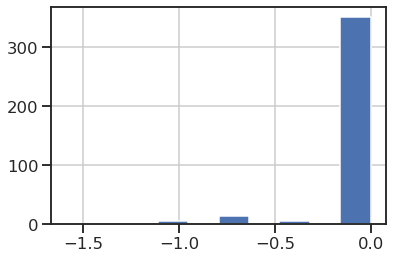

In [ ]:
df3['diff'].hist()

<AxesSubplot:>

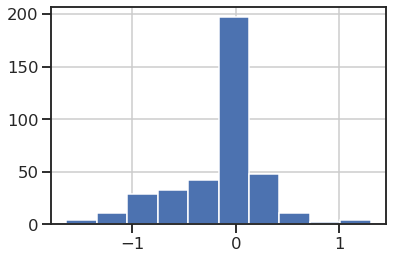

In [12]:
df.decomp_energy.hist()

In [13]:
len(df)

381

In [14]:
len(df[df.decomp_energy < 0])

273

//projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/pred_vs_dft_decomp_energy.svg


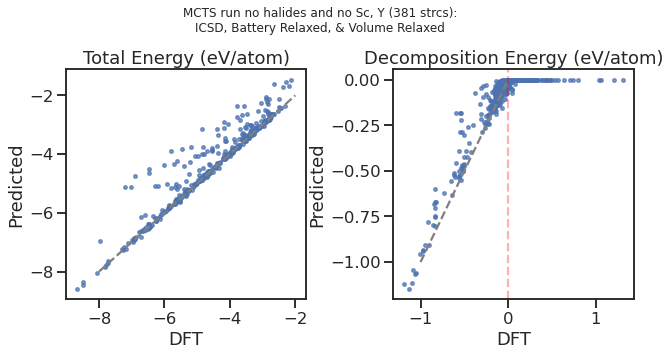

In [34]:
f, (ax2, ax1) = plt.subplots(ncols=2, figsize=(9,5))

# ax1 = sns.scatterplot(data=df, ax=ax1,
ax1 = df.plot.scatter(ax=ax1,
                x='decomp_energy', y='pred_decomp_energy', 
                alpha=0.7, s=12,
)
ax1.plot([-1,0], [-1,0], ls='--', c='gray')
ax1.axvline(0, ls='--', c='red', alpha=0.3)
ax1.set_xlabel("DFT")
ax1.set_ylabel("Predicted")
ax1.set_title("Decomposition Energy (eV/atom)")

df.plot.scatter(x="energyperatom", y="pred_energyperatom", ax=ax2,
                alpha=0.7, s=12,
               )
ax2.plot([-8,-2], [-8,-2], ls='--', c='gray')
ax2.set_xlabel("DFT")
ax2.set_ylabel("Predicted")
ax2.set_title("Total Energy (eV/atom)")

plt.suptitle(f"MCTS run no halides and no Sc, Y ({len(df)} strcs):\n"
             f"ICSD, Battery Relaxed, & Volume Relaxed")
plt.tight_layout()
out_file = f"{viz_dir}/pred_vs_dft_decomp_energy.svg"
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight', dpi=300)

In [85]:
sns.set_context('talk')

//projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa/viz/pred_vs_dft_decomp_energy.svg


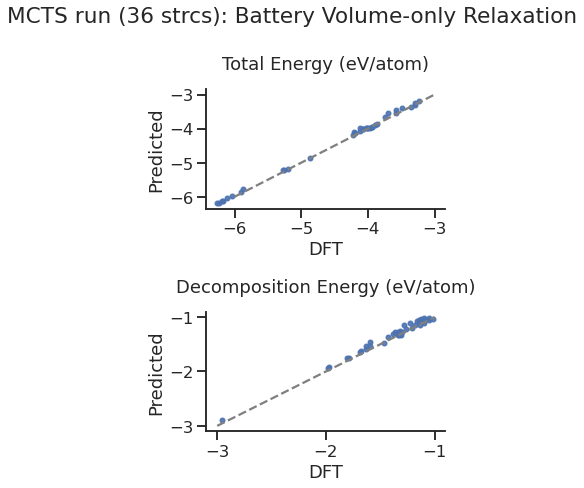

In [ ]:
f, (ax2, ax1) = plt.subplots(nrows=2, figsize=(5,7))

ax = ax1
# ax1 = sns.scatterplot(data=df, ax=ax1,
df.plot.scatter(ax=ax,
                x='decomp_energy', y='pred_decomp_energy', 
                alpha=0.9,
)
ax.plot([-3,-1], [-3,-1], ls='--', c='gray')
ax.set_xlabel("DFT")
ax.set_ylabel("Predicted")
ax.set_title("Decomposition Energy (eV/atom)", pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yticks(ax.get_xticks()[1:-1])

ax = ax2
df.plot.scatter(x="energyperatom", y="pred_energyperatom", ax=ax,
                alpha=0.9,
               )
ax.plot([-6,-3], [-6,-3], ls='--', c='gray')
ax.set_xlabel("DFT")
ax.set_ylabel("Predicted")
ax.set_title("Total Energy (eV/atom)", pad=20)
ax.set_yticks(ax.get_xticks()[1:-1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle(f"MCTS run ({len(df)} strcs): Battery Volume-only Relaxation")
plt.tight_layout()
out_file = f"{viz_dir}/pred_vs_dft_decomp_energy.svg"
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight', dpi=300)

In [100]:
(df.energyperatom - df.pred_energyperatom).abs().mean()

0.05459728797276821

In [27]:
df['ediff'] = (df.energyperatom - df.pred_energyperatom)
df.sort_values('ediff', ascending=False).head(5)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy,ediff
42,Na4Cl1N1/Na4Cl1N1_sg191_icsd_044215_1,12,350.91,-2.140,Na4Cl1N1,Na4Cl1N1_sg191_icsd_044215_1,0.911,-8.324104,-5.275,6.184104
262,Na5Cl2N1/Na5Cl2N1_sg65_icsd_160916_1,16,458.66,-2.337,Na5Cl2N1,Na5Cl2N1_sg65_icsd_160916_1,0.043,-8.028287,-4.895,5.691287
5,Na1Hg1Ge1F1Cl6/Na1Hg1Ge1F1Cl6_sg216_icsd_03960...,40,1018.79,-2.479,Na1Hg1Ge1F1Cl6,Na1Hg1Ge1F1Cl6_sg216_icsd_039604_21,0.653,-7.913330,-4.783,5.434330
8,Na4Cd1N2/Na4Cd1N2_sg64_icsd_047130_1,28,543.24,-2.484,Na4Cd1N2,Na4Cd1N2_sg64_icsd_047130_1,0.609,-7.699223,-4.609,5.215223
499,Na5O1N1/Na5O1N1_sg194_icsd_646285_1,28,584.06,-3.156,Na5O1N1,Na5O1N1_sg194_icsd_646285_1,0.099,-8.355966,-5.103,5.199966


In [29]:
df.sort_values('decomp_energy').head(30)

,decoration,numatoms,relaxedvolume,energyperatom,comp,id,decomp_energy,pred_energyperatom,pred_decomp_energy,ediff
138,Li1Sc1F4/Li1Sc1F4_sg129_icsd_152951_1,12,179.60,-6.036,Li1Sc1F4,Li1Sc1F4_sg129_icsd_152951_1,-1.969,-6.578149,-2.511,0.542149
339,Na1Sc1F4/Na1Sc1F4_sg65_icsd_016492_2,12,144.68,-5.872,Na1Sc1F4,Na1Sc1F4_sg65_icsd_016492_2,-1.953,-7.542525,-3.625,1.670525
401,Na3Sc1F6/Na3Sc1F6_sg182_icsd_076073_1,20,294.55,-5.260,Na3Sc1F6,Na3Sc1F6_sg182_icsd_076073_1,-1.793,-7.848756,-4.381,2.588756
366,Zn2Sc1F7/Zn2Sc1F7_sg11_icsd_024398_1,20,296.13,-4.996,Zn2Sc1F7,Zn2Sc1F7_sg11_icsd_024398_1,-1.731,-5.377619,-2.113,0.381619
438,Na1Sc1Cd1F6/Na1Sc1Cd1F6_sg2_icsd_246190_3,18,321.28,-5.158,Na1Sc1Cd1F6,Na1Sc1Cd1F6_sg2_icsd_246190_3,-1.295,-6.751388,-2.887,1.593388
331,Li1Sc1Br4/Li1Sc1Br4_sg112_icsd_300103_1,12,448.00,-3.861,Li1Sc1Br4,Li1Sc1Br4_sg112_icsd_300103_1,-1.251,-4.750772,-2.141,0.889772
369,Na1Sc1Hg1F6/Na1Sc1Hg1F6_sg113_icsd_202779_3,18,296.36,-4.788,Na1Sc1Hg1F6,Na1Sc1Hg1F6_sg113_icsd_202779_3,-1.251,-6.617060,-3.081,1.829060
424,Na1Sc2Br7/Na1Sc2Br7_sg14_icsd_423437_1,20,860.62,-3.882,Na1Sc2Br7,Na1Sc2Br7_sg14_icsd_423437_1,-1.193,-5.000632,-2.313,1.118632
309,Na1Al1Br4/Na1Al1Br4_sg152_icsd_413436_1,18,688.77,-3.239,Na1Al1Br4,Na1Al1Br4_sg152_icsd_413436_1,-0.907,-4.513700,-2.181,1.274700
377,Na3Sc1Br6/Na3Sc1Br6_sg163_icsd_053533_1,20,633.51,-3.537,Na3Sc1Br6,Na3Sc1Br6_sg163_icsd_053533_1,-0.799,-5.598694,-2.861,2.061694
